In [ ]:
!pip install numpy 
!pip install pandas
!pip install tensorflow

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import time
import matplotlib.pyplot as plt

In [ ]:
EPOCHS = 100001
BATCH_SIZE = 512

In [ ]:
# D(X) -> Resposta do discriminador
def get_y(x):
    return 10 + x*x

# Dado original 
def sample_data(n=10000, scale=100):
    data = []

    x = scale*(np.random.random_sample((n,))-0.5)

    for i in range(n):
        yi = get_y(x[i])
        data.append([x[i], yi])

    return np.array(data)

In [ ]:
# Ruído Z ; G(Z) é dado gerado pela rede neural treinada a partir do feedback do discriminador 
def sample_Z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])

In [ ]:
def generator(hsize=[128, 128],reuse=False):
    #with tf.variable_scope("GAN/Generator",reuse=reuse):
    # Cria o modelo / Funciona como stack de opercoes
    model =  tf.keras.Sequential()
    #model.add(tf.keras.layers.input())
    # Cria primeira camada da rede neural usando os input Z / layer.dense cria uma rede neural do tipo densa 
    model.add(tf.keras.layers.Dense(hsize[0], activation=tf.keras.layers.LeakyReLU(),input_shape=(BATCH_SIZE,2)))
    # Cria a segunda camada da rede usando o input h1(Z)
    model.add( tf.keras.layers.Dense(hsize[1],activation=tf.keras.layers.LeakyReLU()))
    # Cria a de saida camada da rede usando o input h2(h1(Z))
    model.add(tf.keras.layers.Dense(2)) 
    return model

In [ ]:
def discriminator(hsize=[128, 128],reuse=False):
    # Cria o modelo / Funciona como stack de opercoes
    model =  tf.keras.Sequential()
    # Cria primeira camada da rede neural usando os input Z / layer.dense cria uma rede neural do tipo densa 
    model.add(tf.keras.layers.Dense(hsize[0], activation=tf.keras.layers.LeakyReLU(),input_shape=(BATCH_SIZE,2)))
    # Cria a segunda camada da rede usando o input h1(Z)
    model.add( tf.keras.layers.Dense(hsize[1],activation=tf.keras.layers.LeakyReLU()))
    model.add( tf.keras.layers.Dense(hsize[1],activation=tf.keras.layers.LeakyReLU()))
    # Cria a de saida camada da rede usando o input h2(h1(Z))
    model.add(tf.keras.layers.Dense(2))
    # Cria a de saida camada da rede usando o input h3(h2(h1(Z)))
    model.add(tf.keras.layers.Dense(1))
    return model

In [ ]:
def get_compiled_model(model):
    model.compile(
        optimizer="rmsprop",
        loss="sparse_categorical_crossentropy",
        metrics=["sparse_categorical_accuracy"],
    )
    return model

In [ ]:
gen = get_compiled_model(generator())
Z = sample_Z(BATCH_SIZE,2)
#print(Z)
fake_data = gen(Z, training=False)
#print(fake_data)

In [ ]:
dis= get_compiled_model(discriminator())
decision = dis(fake_data, training=False)


In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
# Otimizador
generator_optimizer = tf.keras.optimizers.Adam(1e-3,)
#generator_optimizer =tf.keras.optimizers.RMSprop(1e-3)

discriminator_optimizer = tf.keras.optimizers.Adam(1e-3)
#discriminator_optimizer = tf.keras.optimizers.RMSprop(1e-4)

In [ ]:
epoch_vec=[]
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
@tf.function
def train_step(Y):
    Z = sample_Z(BATCH_SIZE,2) #
    with tf.GradientTape(persistent=True) as tape:
 #     gen = generator()
      fake_data = gen(Z, training=True)  
      real_output = dis(Y, training=True)
      fake_output = dis(fake_data, training=True)
            
      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    #generator_optimizer.minimize(gen_loss)
    gradients_of_generator = tape.gradient(gen_loss, gen.trainable_variables)
    gradients_of_discriminator = tape.gradient(disc_loss, dis.trainable_variables)
    del tape
    generator_optimizer.apply_gradients(zip(gradients_of_generator, gen.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, dis.trainable_variables))


In [ ]:
epoch_vec = []
for x in range(EPOCHS):
    Y = sample_data(n= BATCH_SIZE)
    Y = tf.convert_to_tensor(Y)
    train_step(Y)
    if x in [2500,5000,7500,10000]: 
      epoch_vec.append(gen(Z,training=False))
    

In [ ]:
Z = sample_Z(BATCH_SIZE,2)
GZ = gen(Z,training=False)
x_plot = sample_data(n=BATCH_SIZE)
len(x_plot)

512

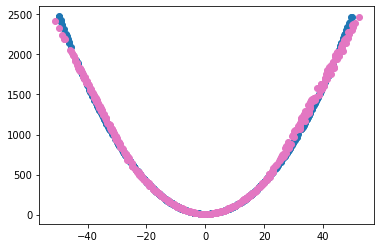

In [ ]:
plt.figure()
xax = plt.scatter(x_plot[:,0], x_plot[:,1])
gax = plt.scatter(GZ[:,0],GZ[:,1],c='#e377c2')